In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Sep  4 23:42:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   56C    P2    58W / 250W |   6313MiB / 12066MiB |     55%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 200

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'TEST_AllCNN_control_Adam'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/AllCNN/' + folder
output = Path(folder)


# Size of batches
batch_size = 128 ## was 64
# How fast to learn
learning_rate = 1.5e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
#AllCNN imports
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

# From model/utilities.py
#from model.utilities import load_full_state, count_parameters, Params

from functions.my_training_kde import adaptivetrainNet
from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:2"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

model = Model()
model.to(device)

loss = Loss(epsilon=1e-5,coefficient=2.5)

Let's move the model's weight matricies to the GPU:

In [11]:
from functions.mod_adam import Adam
optimizer = Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# ## finished at training cost = 1.46, validation cost = 1.50
d_folder = 'TEST_AllCNN_adaptive_fixedcarefulAdam'
d_name = d_folder
suffix = 'init'
dict_name = 'baileyds/AllCNN/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=True)

#mine
torch.save(model.state_dict(), output / f'{name}_init.pyt')
param_states.append(get_param_state(model))


dict_name =  baileyds/AllCNN/TEST_AllCNN_adaptive_fixedcarefulAdam/TEST_AllCNN_adaptive_fixedcarefulAdam_init.pyt


In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
  #                          device=device,
                            masking=True,
                            shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 21.38 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 22.5 s
Constructing 160000 event dataset took 0.8073 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.821 s
Constructing 20000 event dataset took 0.1114 s


<IPython.core.display.Javascript object>


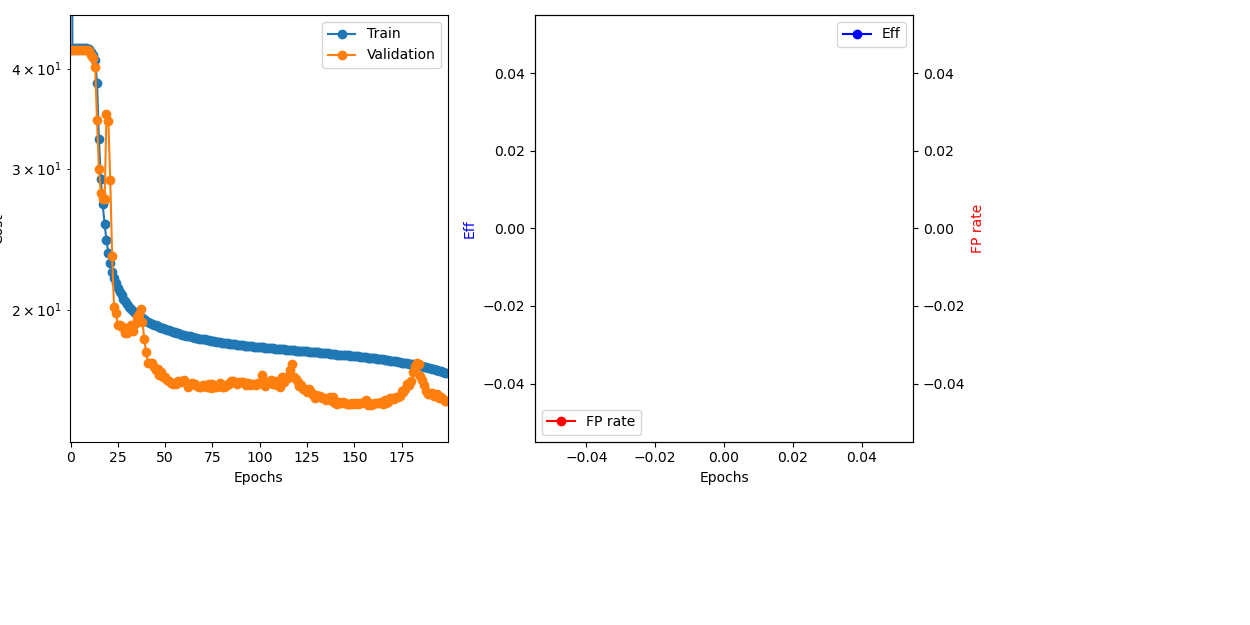

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader, 
                        n_epochs, device=device, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 1250, val = 157


Epoch 0: train=290.176, val=42.2571, took 255.73 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=42.4251, val=42.2359, took 143.06 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=42.4117, val=42.2285, took 132.96 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 3: train=42.4062, val=42.2234, took 126.19 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 4: train=42.4011, val=42.2178, took 127.77 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 5: train=42.3949, val=42.2106, took 163.94 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 6: train=42.3884, val=42.2059, took 196.52 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 7: train=42.3853, val=42.2042, took 191.18 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 8: train=42.3831, val=42.2005, took 186.68 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 9: train=42.3784, val=42.1922, took 189.1 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 10: train=42.3316, val=42.0285, took 186.67 s
  Validation Found 0 of 108007, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 11: train=41.9818, val=41.6097, took 173.32 s
  Validation Found 445 of 108007, added 67 (eff 0.41%) (0.00335 FP/event)


Epoch 12: train=41.6389, val=41.2236, took 182.32 s
  Validation Found 1151 of 108007, added 118 (eff 1.07%) (0.0059 FP/event)


Epoch 13: train=41.0413, val=40.1856, took 186.76 s
  Validation Found 3012 of 108007, added 172 (eff 2.79%) (0.0086 FP/event)


Epoch 14: train=38.4202, val=34.4795, took 187.94 s
  Validation Found 11303 of 108007, added 234 (eff 10.47%) (0.0117 FP/event)


Epoch 15: train=32.6785, val=29.953, took 189.81 s
  Validation Found 40773 of 108007, added 1086 (eff 37.75%) (0.0543 FP/event)


Epoch 16: train=29.1527, val=27.968, took 186.91 s
  Validation Found 57772 of 108007, added 1837 (eff 53.49%) (0.0918 FP/event)


Epoch 17: train=27.0659, val=27.4691, took 186.71 s
  Validation Found 67816 of 108007, added 2557 (eff 62.79%) (0.128 FP/event)


Epoch 18: train=25.5984, val=27.4779, took 185.95 s
  Validation Found 73617 of 108007, added 3047 (eff 68.16%) (0.152 FP/event)


Epoch 19: train=24.4069, val=35.0795, took 186.73 s
  Validation Found 79293 of 108007, added 4385 (eff 73.41%) (0.219 FP/event)


Epoch 20: train=23.5207, val=34.3564, took 188.32 s
  Validation Found 80734 of 108007, added 4596 (eff 74.75%) (0.23 FP/event)


Epoch 21: train=22.8378, val=29.0112, took 185.54 s
  Validation Found 80963 of 108007, added 4215 (eff 74.96%) (0.211 FP/event)


Epoch 22: train=22.3074, val=23.3061, took 280.54 s
  Validation Found 80374 of 108007, added 3587 (eff 74.42%) (0.179 FP/event)


Epoch 23: train=21.9022, val=20.1606, took 202.41 s
  Validation Found 79179 of 108007, added 2951 (eff 73.31%) (0.148 FP/event)


Epoch 24: train=21.5817, val=19.7906, took 191.93 s
  Validation Found 79855 of 108007, added 3000 (eff 73.94%) (0.15 FP/event)


Epoch 25: train=21.2923, val=19.1574, took 190.2 s
  Validation Found 80026 of 108007, added 2973 (eff 74.09%) (0.149 FP/event)


Epoch 26: train=21.0596, val=19.1444, took 187.55 s
  Validation Found 80771 of 108007, added 3074 (eff 74.78%) (0.154 FP/event)


Epoch 27: train=20.8342, val=19.0278, took 186.42 s
  Validation Found 81345 of 108007, added 3172 (eff 75.31%) (0.159 FP/event)


Epoch 28: train=20.643, val=19.0467, took 188.99 s
  Validation Found 81929 of 108007, added 3256 (eff 75.86%) (0.163 FP/event)


Epoch 29: train=20.4784, val=18.6782, took 188.6 s
  Validation Found 82118 of 108007, added 3260 (eff 76.03%) (0.163 FP/event)


Epoch 30: train=20.323, val=18.7138, took 188.62 s
  Validation Found 82673 of 108007, added 3413 (eff 76.54%) (0.171 FP/event)


Epoch 31: train=20.1785, val=18.9385, took 187.57 s
  Validation Found 83225 of 108007, added 3552 (eff 77.06%) (0.178 FP/event)


Epoch 32: train=20.0476, val=19.1103, took 185.75 s
  Validation Found 83685 of 108007, added 3748 (eff 77.48%) (0.187 FP/event)


Epoch 33: train=19.9404, val=18.8079, took 184.76 s
  Validation Found 83757 of 108007, added 3689 (eff 77.55%) (0.184 FP/event)


Epoch 34: train=19.8289, val=19.2122, took 185.46 s
  Validation Found 84184 of 108007, added 3861 (eff 77.94%) (0.193 FP/event)


Epoch 35: train=19.7379, val=19.5929, took 186.41 s
  Validation Found 84563 of 108007, added 4127 (eff 78.29%) (0.206 FP/event)


Epoch 36: train=19.6532, val=19.7763, took 187.69 s
  Validation Found 84774 of 108007, added 4198 (eff 78.49%) (0.21 FP/event)


Epoch 37: train=19.5734, val=20.0348, took 185.35 s
  Validation Found 85081 of 108007, added 4472 (eff 78.77%) (0.224 FP/event)


Epoch 38: train=19.5188, val=19.2896, took 184.21 s
  Validation Found 84901 of 108007, added 4183 (eff 78.61%) (0.209 FP/event)


Epoch 39: train=19.4453, val=18.37, took 205.38 s
  Validation Found 84744 of 108007, added 3994 (eff 78.46%) (0.2 FP/event)


Epoch 40: train=19.376, val=17.6856, took 254.57 s
  Validation Found 84439 of 108007, added 3729 (eff 78.18%) (0.186 FP/event)


Epoch 41: train=19.3126, val=17.1378, took 198.1 s
  Validation Found 84136 of 108007, added 3540 (eff 77.90%) (0.177 FP/event)


Epoch 42: train=19.2669, val=17.1369, took 198.01 s
  Validation Found 84279 of 108007, added 3567 (eff 78.03%) (0.178 FP/event)


Epoch 43: train=19.2103, val=17.1686, took 196.25 s
  Validation Found 84489 of 108007, added 3636 (eff 78.23%) (0.182 FP/event)


Epoch 44: train=19.1568, val=16.974, took 189.36 s
  Validation Found 84372 of 108007, added 3572 (eff 78.12%) (0.179 FP/event)


Epoch 45: train=19.1148, val=16.8004, took 191.25 s
  Validation Found 84297 of 108007, added 3522 (eff 78.05%) (0.176 FP/event)


Epoch 46: train=19.069, val=16.8565, took 191.03 s
  Validation Found 84501 of 108007, added 3545 (eff 78.24%) (0.177 FP/event)


Epoch 47: train=19.0348, val=16.5652, took 192.85 s
  Validation Found 84119 of 108007, added 3399 (eff 77.88%) (0.17 FP/event)


Epoch 48: train=18.9937, val=16.7182, took 199.26 s
  Validation Found 84629 of 108007, added 3598 (eff 78.36%) (0.18 FP/event)


Epoch 49: train=18.9438, val=16.4652, took 197.66 s
  Validation Found 84262 of 108007, added 3385 (eff 78.02%) (0.169 FP/event)


Epoch 50: train=18.8989, val=16.4952, took 197.38 s
  Validation Found 84561 of 108007, added 3510 (eff 78.29%) (0.175 FP/event)


Epoch 51: train=18.8714, val=16.3279, took 196.17 s
  Validation Found 84205 of 108007, added 3385 (eff 77.96%) (0.169 FP/event)


Epoch 52: train=18.8361, val=16.275, took 194.88 s
  Validation Found 84160 of 108007, added 3355 (eff 77.92%) (0.168 FP/event)


Epoch 53: train=18.7929, val=16.2027, took 188.93 s
  Validation Found 84068 of 108007, added 3286 (eff 77.84%) (0.164 FP/event)


Epoch 54: train=18.7657, val=16.1394, took 189.94 s
  Validation Found 83821 of 108007, added 3238 (eff 77.61%) (0.162 FP/event)


Epoch 55: train=18.7384, val=16.1897, took 186.28 s
  Validation Found 84435 of 108007, added 3376 (eff 78.18%) (0.169 FP/event)


Epoch 56: train=18.7018, val=16.1703, took 189.38 s
  Validation Found 84568 of 108007, added 3421 (eff 78.30%) (0.171 FP/event)


Epoch 57: train=18.6829, val=16.2769, took 164.22 s
  Validation Found 85005 of 108007, added 3605 (eff 78.70%) (0.18 FP/event)


Epoch 58: train=18.6374, val=16.2334, took 187.46 s
  Validation Found 85037 of 108007, added 3628 (eff 78.73%) (0.181 FP/event)


Epoch 59: train=18.6126, val=16.3064, took 238.91 s
  Validation Found 85291 of 108007, added 3654 (eff 78.97%) (0.183 FP/event)


Epoch 60: train=18.5875, val=16.3236, took 181.84 s
  Validation Found 85489 of 108007, added 3854 (eff 79.15%) (0.193 FP/event)


Epoch 61: train=18.5561, val=16.2012, took 181.2 s
  Validation Found 85356 of 108007, added 3737 (eff 79.03%) (0.187 FP/event)


Epoch 62: train=18.537, val=16.014, took 181.77 s
  Validation Found 84987 of 108007, added 3533 (eff 78.69%) (0.177 FP/event)


Epoch 63: train=18.5236, val=16.1555, took 182.6 s
  Validation Found 85458 of 108007, added 3704 (eff 79.12%) (0.185 FP/event)


Epoch 64: train=18.4911, val=16.1767, took 180.53 s
  Validation Found 85581 of 108007, added 3757 (eff 79.24%) (0.188 FP/event)


Epoch 65: train=18.4667, val=16.1537, took 181.84 s
  Validation Found 85581 of 108007, added 3690 (eff 79.24%) (0.184 FP/event)


Epoch 66: train=18.4453, val=16.1536, took 180.11 s
  Validation Found 85679 of 108007, added 3769 (eff 79.33%) (0.188 FP/event)


Epoch 67: train=18.4123, val=16.037, took 180.57 s
  Validation Found 85589 of 108007, added 3724 (eff 79.24%) (0.186 FP/event)


Epoch 68: train=18.4057, val=16.007, took 181.5 s
  Validation Found 85624 of 108007, added 3695 (eff 79.28%) (0.185 FP/event)


Epoch 69: train=18.3853, val=16.0035, took 183.5 s
  Validation Found 85716 of 108007, added 3781 (eff 79.36%) (0.189 FP/event)


Epoch 70: train=18.3591, val=16.0807, took 185.34 s
  Validation Found 85891 of 108007, added 3900 (eff 79.52%) (0.195 FP/event)


Epoch 71: train=18.3558, val=16.12, took 185.29 s
  Validation Found 85953 of 108007, added 3861 (eff 79.58%) (0.193 FP/event)


Epoch 72: train=18.324, val=16.0281, took 183.01 s
  Validation Found 85838 of 108007, added 3791 (eff 79.47%) (0.19 FP/event)


Epoch 73: train=18.3014, val=16.1524, took 210.95 s
  Validation Found 86023 of 108007, added 3907 (eff 79.65%) (0.195 FP/event)


Epoch 74: train=18.2808, val=15.9801, took 232.4 s
  Validation Found 85941 of 108007, added 3807 (eff 79.57%) (0.19 FP/event)


Epoch 75: train=18.2644, val=16.1329, took 184.92 s
  Validation Found 86122 of 108007, added 3918 (eff 79.74%) (0.196 FP/event)


Epoch 76: train=18.2574, val=16.0132, took 184.38 s
  Validation Found 85982 of 108007, added 3838 (eff 79.61%) (0.192 FP/event)


Epoch 77: train=18.243, val=16.0, took 184.36 s
  Validation Found 86154 of 108007, added 3978 (eff 79.77%) (0.199 FP/event)


Epoch 78: train=18.2263, val=16.0411, took 185.66 s
  Validation Found 86218 of 108007, added 4013 (eff 79.83%) (0.201 FP/event)


Epoch 79: train=18.2023, val=16.1991, took 189.54 s
  Validation Found 86445 of 108007, added 4149 (eff 80.04%) (0.207 FP/event)


Epoch 80: train=18.1912, val=16.0173, took 178.65 s
  Validation Found 86265 of 108007, added 3952 (eff 79.87%) (0.198 FP/event)


Epoch 81: train=18.183, val=16.0293, took 180.16 s
  Validation Found 86257 of 108007, added 4009 (eff 79.86%) (0.2 FP/event)


Epoch 82: train=18.1705, val=16.0349, took 180.48 s
  Validation Found 86347 of 108007, added 4091 (eff 79.95%) (0.205 FP/event)


Epoch 83: train=18.1552, val=16.1464, took 181.71 s
  Validation Found 86468 of 108007, added 4146 (eff 80.06%) (0.207 FP/event)


Epoch 84: train=18.1434, val=16.1299, took 179.07 s
  Validation Found 86459 of 108007, added 4109 (eff 80.05%) (0.205 FP/event)


Epoch 85: train=18.1179, val=16.2765, took 211.89 s
  Validation Found 86649 of 108007, added 4266 (eff 80.23%) (0.213 FP/event)


Epoch 86: train=18.1116, val=16.2818, took 218.1 s
  Validation Found 86654 of 108007, added 4251 (eff 80.23%) (0.213 FP/event)


Epoch 87: train=18.1065, val=16.2521, took 187.36 s
  Validation Found 86621 of 108007, added 4232 (eff 80.20%) (0.212 FP/event)


Epoch 88: train=18.0901, val=16.1468, took 188.23 s
  Validation Found 86617 of 108007, added 4184 (eff 80.20%) (0.209 FP/event)


Epoch 89: train=18.071, val=16.2306, took 192.21 s
  Validation Found 86646 of 108007, added 4219 (eff 80.22%) (0.211 FP/event)


Epoch 90: train=18.0678, val=16.2225, took 186.09 s
  Validation Found 86697 of 108007, added 4251 (eff 80.27%) (0.213 FP/event)


Epoch 91: train=18.0542, val=16.2225, took 184.28 s
  Validation Found 86738 of 108007, added 4283 (eff 80.31%) (0.214 FP/event)


Epoch 92: train=18.0366, val=16.2055, took 183.06 s
  Validation Found 86768 of 108007, added 4308 (eff 80.34%) (0.215 FP/event)


Epoch 93: train=18.0376, val=16.0841, took 184.38 s
  Validation Found 86682 of 108007, added 4225 (eff 80.26%) (0.211 FP/event)


Epoch 94: train=18.0217, val=16.1954, took 179.88 s
  Validation Found 86768 of 108007, added 4275 (eff 80.34%) (0.214 FP/event)


Epoch 95: train=18.0172, val=16.102, took 182.58 s
  Validation Found 86745 of 108007, added 4285 (eff 80.31%) (0.214 FP/event)


Epoch 96: train=17.9994, val=16.1304, took 178.69 s
  Validation Found 86750 of 108007, added 4230 (eff 80.32%) (0.211 FP/event)


Epoch 97: train=17.982, val=16.1674, took 152.33 s
  Validation Found 86759 of 108007, added 4243 (eff 80.33%) (0.212 FP/event)


Epoch 98: train=17.974, val=16.0826, took 186.36 s
  Validation Found 86810 of 108007, added 4326 (eff 80.37%) (0.216 FP/event)


Epoch 99: train=17.9485, val=16.1746, took 185.94 s
  Validation Found 86885 of 108007, added 4370 (eff 80.44%) (0.218 FP/event)


Epoch 100: train=17.9533, val=16.1833, took 185.93 s
  Validation Found 86880 of 108007, added 4336 (eff 80.44%) (0.217 FP/event)


Epoch 101: train=17.9399, val=16.5654, took 185.18 s
  Validation Found 86999 of 108007, added 4421 (eff 80.55%) (0.221 FP/event)


Epoch 102: train=17.9381, val=16.2285, took 182.03 s
  Validation Found 86943 of 108007, added 4434 (eff 80.50%) (0.222 FP/event)


Epoch 103: train=17.9168, val=16.0506, took 181.82 s
  Validation Found 86884 of 108007, added 4383 (eff 80.44%) (0.219 FP/event)


Epoch 104: train=17.912, val=16.2324, took 179.77 s
  Validation Found 86956 of 108007, added 4400 (eff 80.51%) (0.22 FP/event)


Epoch 105: train=17.9004, val=16.2489, took 176.64 s
  Validation Found 87047 of 108007, added 4544 (eff 80.59%) (0.227 FP/event)


Epoch 106: train=17.8979, val=16.3433, took 176.56 s
  Validation Found 87039 of 108007, added 4378 (eff 80.59%) (0.219 FP/event)


Epoch 107: train=17.8921, val=16.1639, took 182.32 s
  Validation Found 86960 of 108007, added 4334 (eff 80.51%) (0.217 FP/event)


Epoch 108: train=17.8772, val=16.2753, took 180.34 s
  Validation Found 86996 of 108007, added 4396 (eff 80.55%) (0.22 FP/event)


Epoch 109: train=17.8653, val=16.1233, took 177.1 s
  Validation Found 86952 of 108007, added 4372 (eff 80.51%) (0.219 FP/event)


Epoch 110: train=17.8471, val=16.155, took 179.79 s
  Validation Found 86950 of 108007, added 4339 (eff 80.50%) (0.217 FP/event)


Epoch 111: train=17.8506, val=16.0216, took 184.76 s
  Validation Found 86957 of 108007, added 4378 (eff 80.51%) (0.219 FP/event)


Epoch 112: train=17.8389, val=16.4988, took 179.45 s
  Validation Found 87201 of 108007, added 4577 (eff 80.74%) (0.229 FP/event)


Epoch 113: train=17.8414, val=16.2302, took 179.1 s
  Validation Found 87090 of 108007, added 4478 (eff 80.63%) (0.224 FP/event)


Epoch 114: train=17.8245, val=16.4926, took 175.19 s
  Validation Found 87219 of 108007, added 4563 (eff 80.75%) (0.228 FP/event)


Epoch 115: train=17.8128, val=16.4456, took 181.2 s
  Validation Found 87141 of 108007, added 4483 (eff 80.68%) (0.224 FP/event)


Epoch 116: train=17.8005, val=16.8192, took 182.1 s
  Validation Found 87407 of 108007, added 4715 (eff 80.93%) (0.236 FP/event)


Epoch 117: train=17.795, val=17.0954, took 178.45 s
  Validation Found 87463 of 108007, added 4806 (eff 80.98%) (0.24 FP/event)


Epoch 118: train=17.7897, val=16.4885, took 177.18 s
  Validation Found 87297 of 108007, added 4589 (eff 80.83%) (0.229 FP/event)


Epoch 119: train=17.7785, val=16.392, took 177.42 s
  Validation Found 87281 of 108007, added 4575 (eff 80.81%) (0.229 FP/event)


Epoch 120: train=17.7719, val=16.2432, took 178.18 s
  Validation Found 87214 of 108007, added 4480 (eff 80.75%) (0.224 FP/event)


Epoch 121: train=17.7631, val=16.0772, took 177.35 s
  Validation Found 87085 of 108007, added 4400 (eff 80.63%) (0.22 FP/event)


Epoch 122: train=17.7625, val=16.1047, took 177.83 s
  Validation Found 87198 of 108007, added 4478 (eff 80.73%) (0.224 FP/event)


Epoch 123: train=17.7388, val=15.9116, took 178.77 s
  Validation Found 87124 of 108007, added 4383 (eff 80.67%) (0.219 FP/event)


Epoch 124: train=17.739, val=15.9005, took 177.39 s
  Validation Found 87031 of 108007, added 4300 (eff 80.58%) (0.215 FP/event)


Epoch 125: train=17.7315, val=15.7786, took 178.41 s
  Validation Found 87030 of 108007, added 4307 (eff 80.58%) (0.215 FP/event)


Epoch 126: train=17.7126, val=15.9259, took 177.21 s
  Validation Found 87179 of 108007, added 4447 (eff 80.72%) (0.222 FP/event)


Epoch 127: train=17.7051, val=15.8004, took 181.28 s
  Validation Found 87062 of 108007, added 4304 (eff 80.61%) (0.215 FP/event)


Epoch 128: train=17.7088, val=15.6432, took 177.7 s
  Validation Found 86957 of 108007, added 4187 (eff 80.51%) (0.209 FP/event)


Epoch 129: train=17.6938, val=15.4956, took 176.69 s
  Validation Found 86859 of 108007, added 4161 (eff 80.42%) (0.208 FP/event)


Epoch 130: train=17.6939, val=15.6346, took 177.48 s
  Validation Found 86976 of 108007, added 4171 (eff 80.53%) (0.209 FP/event)


Epoch 131: train=17.6835, val=15.6167, took 175.6 s
  Validation Found 86990 of 108007, added 4217 (eff 80.54%) (0.211 FP/event)


Epoch 132: train=17.6681, val=15.6179, took 175.55 s
  Validation Found 87009 of 108007, added 4209 (eff 80.56%) (0.21 FP/event)


Epoch 133: train=17.6618, val=15.4979, took 178.69 s
  Validation Found 86898 of 108007, added 4143 (eff 80.46%) (0.207 FP/event)


Epoch 134: train=17.6527, val=15.4901, took 177.53 s
  Validation Found 86940 of 108007, added 4168 (eff 80.49%) (0.208 FP/event)


Epoch 135: train=17.645, val=15.4421, took 177.28 s
  Validation Found 86892 of 108007, added 4127 (eff 80.45%) (0.206 FP/event)


Epoch 136: train=17.6394, val=15.5296, took 176.44 s
  Validation Found 86996 of 108007, added 4236 (eff 80.55%) (0.212 FP/event)


Epoch 137: train=17.6295, val=15.5653, took 177.99 s
  Validation Found 87009 of 108007, added 4136 (eff 80.56%) (0.207 FP/event)


Epoch 138: train=17.6153, val=15.3945, took 177.3 s
  Validation Found 86894 of 108007, added 4131 (eff 80.45%) (0.207 FP/event)


Epoch 139: train=17.6155, val=15.5377, took 175.37 s
  Validation Found 86988 of 108007, added 4123 (eff 80.54%) (0.206 FP/event)


Epoch 140: train=17.6046, val=15.2751, took 177.47 s
  Validation Found 86700 of 108007, added 3927 (eff 80.27%) (0.196 FP/event)


Epoch 141: train=17.5749, val=15.265, took 179.22 s
  Validation Found 86775 of 108007, added 4019 (eff 80.34%) (0.201 FP/event)


Epoch 142: train=17.5747, val=15.3132, took 177.24 s
  Validation Found 86806 of 108007, added 3968 (eff 80.37%) (0.198 FP/event)


Epoch 143: train=17.5689, val=15.2821, took 176.49 s
  Validation Found 86780 of 108007, added 3968 (eff 80.35%) (0.198 FP/event)


Epoch 144: train=17.5529, val=15.3129, took 176.49 s
  Validation Found 86862 of 108007, added 4050 (eff 80.42%) (0.202 FP/event)


Epoch 145: train=17.5441, val=15.2978, took 177.19 s
  Validation Found 86857 of 108007, added 4066 (eff 80.42%) (0.203 FP/event)


Epoch 146: train=17.5367, val=15.2392, took 175.93 s
  Validation Found 86840 of 108007, added 4082 (eff 80.40%) (0.204 FP/event)


Epoch 147: train=17.5349, val=15.2389, took 176.68 s
  Validation Found 86812 of 108007, added 3950 (eff 80.38%) (0.197 FP/event)


Epoch 148: train=17.521, val=15.2472, took 176.41 s
  Validation Found 86848 of 108007, added 4015 (eff 80.41%) (0.201 FP/event)


Epoch 149: train=17.504, val=15.3007, took 175.94 s
  Validation Found 86941 of 108007, added 4043 (eff 80.50%) (0.202 FP/event)


Epoch 150: train=17.4901, val=15.2464, took 175.36 s
  Validation Found 86852 of 108007, added 3944 (eff 80.41%) (0.197 FP/event)


Epoch 151: train=17.494, val=15.2924, took 177.74 s
  Validation Found 87003 of 108007, added 4106 (eff 80.55%) (0.205 FP/event)


Epoch 152: train=17.4846, val=15.2439, took 176.56 s
  Validation Found 86930 of 108007, added 4063 (eff 80.49%) (0.203 FP/event)


Epoch 153: train=17.4612, val=15.2906, took 176.26 s
  Validation Found 86971 of 108007, added 4015 (eff 80.52%) (0.201 FP/event)


Epoch 154: train=17.4628, val=15.277, took 176.83 s
  Validation Found 87028 of 108007, added 4058 (eff 80.58%) (0.203 FP/event)


Epoch 155: train=17.4404, val=15.3268, took 177.53 s
  Validation Found 87095 of 108007, added 4099 (eff 80.64%) (0.205 FP/event)


Epoch 156: train=17.4437, val=15.4153, took 176.78 s
  Validation Found 87201 of 108007, added 4196 (eff 80.74%) (0.21 FP/event)


Epoch 157: train=17.4235, val=15.1988, took 177.29 s
  Validation Found 87062 of 108007, added 4004 (eff 80.61%) (0.2 FP/event)


Epoch 158: train=17.4129, val=15.2693, took 175.78 s
  Validation Found 87174 of 108007, added 4088 (eff 80.71%) (0.204 FP/event)


Epoch 159: train=17.4052, val=15.2213, took 175.25 s
  Validation Found 87204 of 108007, added 4097 (eff 80.74%) (0.205 FP/event)


Epoch 160: train=17.3897, val=15.2467, took 177.31 s
  Validation Found 87163 of 108007, added 4036 (eff 80.70%) (0.202 FP/event)


Epoch 161: train=17.3791, val=15.2691, took 178.61 s
  Validation Found 87217 of 108007, added 4039 (eff 80.75%) (0.202 FP/event)


Epoch 162: train=17.365, val=15.295, took 182.25 s
  Validation Found 87291 of 108007, added 4120 (eff 80.82%) (0.206 FP/event)


Epoch 163: train=17.3643, val=15.2831, took 182.93 s
  Validation Found 87306 of 108007, added 4209 (eff 80.83%) (0.21 FP/event)


Epoch 164: train=17.3359, val=15.3342, took 181.99 s
  Validation Found 87357 of 108007, added 4221 (eff 80.88%) (0.211 FP/event)


Epoch 165: train=17.3329, val=15.2546, took 176.89 s
  Validation Found 87307 of 108007, added 4131 (eff 80.83%) (0.207 FP/event)


Epoch 166: train=17.3053, val=15.4059, took 176.27 s
  Validation Found 87463 of 108007, added 4161 (eff 80.98%) (0.208 FP/event)


Epoch 167: train=17.3011, val=15.3089, took 177.09 s
  Validation Found 87411 of 108007, added 4132 (eff 80.93%) (0.207 FP/event)


Epoch 168: train=17.2918, val=15.3496, took 193.67 s
  Validation Found 87496 of 108007, added 4152 (eff 81.01%) (0.208 FP/event)


Epoch 169: train=17.2713, val=15.5208, took 174.95 s
  Validation Found 87652 of 108007, added 4353 (eff 81.15%) (0.218 FP/event)


Epoch 170: train=17.2577, val=15.4909, took 166.95 s
  Validation Found 87633 of 108007, added 4307 (eff 81.14%) (0.215 FP/event)


Epoch 171: train=17.2548, val=15.4768, took 168.15 s
  Validation Found 87619 of 108007, added 4286 (eff 81.12%) (0.214 FP/event)


Epoch 172: train=17.2302, val=15.5663, took 166.43 s
  Validation Found 87686 of 108007, added 4287 (eff 81.19%) (0.214 FP/event)


Epoch 173: train=17.2118, val=15.555, took 181.7 s
  Validation Found 87723 of 108007, added 4311 (eff 81.22%) (0.216 FP/event)


Epoch 174: train=17.1945, val=15.602, took 199.37 s
  Validation Found 87783 of 108007, added 4388 (eff 81.28%) (0.219 FP/event)


Epoch 175: train=17.1773, val=15.8224, took 199.29 s
  Validation Found 87920 of 108007, added 4441 (eff 81.40%) (0.222 FP/event)


Epoch 176: train=17.1644, val=15.7892, took 200.67 s
  Validation Found 87940 of 108007, added 4476 (eff 81.42%) (0.224 FP/event)


Epoch 177: train=17.1641, val=15.8984, took 199.48 s
  Validation Found 87989 of 108007, added 4463 (eff 81.47%) (0.223 FP/event)


Epoch 178: train=17.1365, val=16.1686, took 199.18 s
  Validation Found 88084 of 108007, added 4504 (eff 81.55%) (0.225 FP/event)


Epoch 179: train=17.1245, val=16.1099, took 199.49 s
  Validation Found 88182 of 108007, added 4574 (eff 81.64%) (0.229 FP/event)


Epoch 180: train=17.0966, val=16.3074, took 200.98 s
  Validation Found 88287 of 108007, added 4613 (eff 81.74%) (0.231 FP/event)


Epoch 181: train=17.0855, val=16.713, took 222.02 s
  Validation Found 88463 of 108007, added 4765 (eff 81.90%) (0.238 FP/event)


Epoch 182: train=17.0766, val=16.9957, took 180.63 s
  Validation Found 88509 of 108007, added 4745 (eff 81.95%) (0.237 FP/event)


Epoch 183: train=17.0493, val=17.1512, took 179.52 s
  Validation Found 88587 of 108007, added 4778 (eff 82.02%) (0.239 FP/event)


Epoch 184: train=17.0302, val=17.1033, took 202.34 s
  Validation Found 88566 of 108007, added 4751 (eff 82.00%) (0.238 FP/event)


Epoch 185: train=17.0144, val=16.5467, took 220.03 s
  Validation Found 88458 of 108007, added 4611 (eff 81.90%) (0.231 FP/event)


Epoch 186: train=16.9971, val=16.333, took 217.29 s
  Validation Found 88375 of 108007, added 4535 (eff 81.82%) (0.227 FP/event)


Epoch 187: train=16.9623, val=16.1088, took 219.02 s
  Validation Found 88349 of 108007, added 4514 (eff 81.80%) (0.226 FP/event)


Epoch 188: train=16.9428, val=15.8489, took 218.92 s
  Validation Found 88325 of 108007, added 4404 (eff 81.78%) (0.22 FP/event)


Epoch 189: train=16.9249, val=15.7135, took 218.08 s
  Validation Found 88271 of 108007, added 4356 (eff 81.73%) (0.218 FP/event)


Epoch 190: train=16.8976, val=15.6904, took 218.02 s
  Validation Found 88263 of 108007, added 4387 (eff 81.72%) (0.219 FP/event)


Epoch 191: train=16.8645, val=15.7441, took 218.76 s
  Validation Found 88299 of 108007, added 4390 (eff 81.75%) (0.219 FP/event)


Epoch 192: train=16.8413, val=15.5876, took 217.64 s
  Validation Found 88238 of 108007, added 4285 (eff 81.70%) (0.214 FP/event)


Epoch 193: train=16.8183, val=15.6529, took 216.51 s
  Validation Found 88305 of 108007, added 4347 (eff 81.76%) (0.217 FP/event)


Epoch 194: train=16.7969, val=15.7035, took 216.25 s
  Validation Found 88406 of 108007, added 4482 (eff 81.85%) (0.224 FP/event)


Epoch 195: train=16.7692, val=15.5279, took 216.52 s
  Validation Found 88324 of 108007, added 4318 (eff 81.78%) (0.216 FP/event)


Epoch 196: train=16.7409, val=15.5398, took 216.38 s
  Validation Found 88355 of 108007, added 4287 (eff 81.80%) (0.214 FP/event)


Epoch 197: train=16.7151, val=15.4819, took 215.97 s
  Validation Found 88395 of 108007, added 4339 (eff 81.84%) (0.217 FP/event)


Epoch 198: train=16.68, val=15.3738, took 214.82 s
  Validation Found 88351 of 108007, added 4345 (eff 81.80%) (0.217 FP/event)


Epoch 199: train=16.6696, val=15.3647, took 216.16 s
  Validation Found 88390 of 108007, added 4327 (eff 81.84%) (0.216 FP/event)



Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


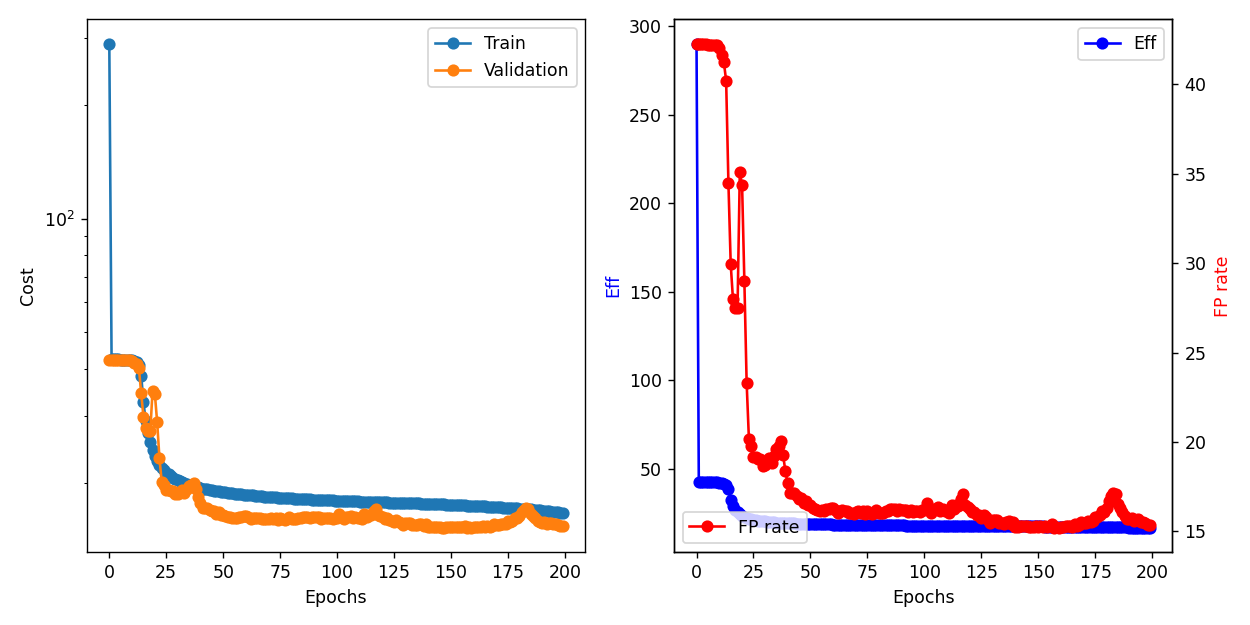

In [24]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [20]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0
100


<IPython.core.display.Javascript object>


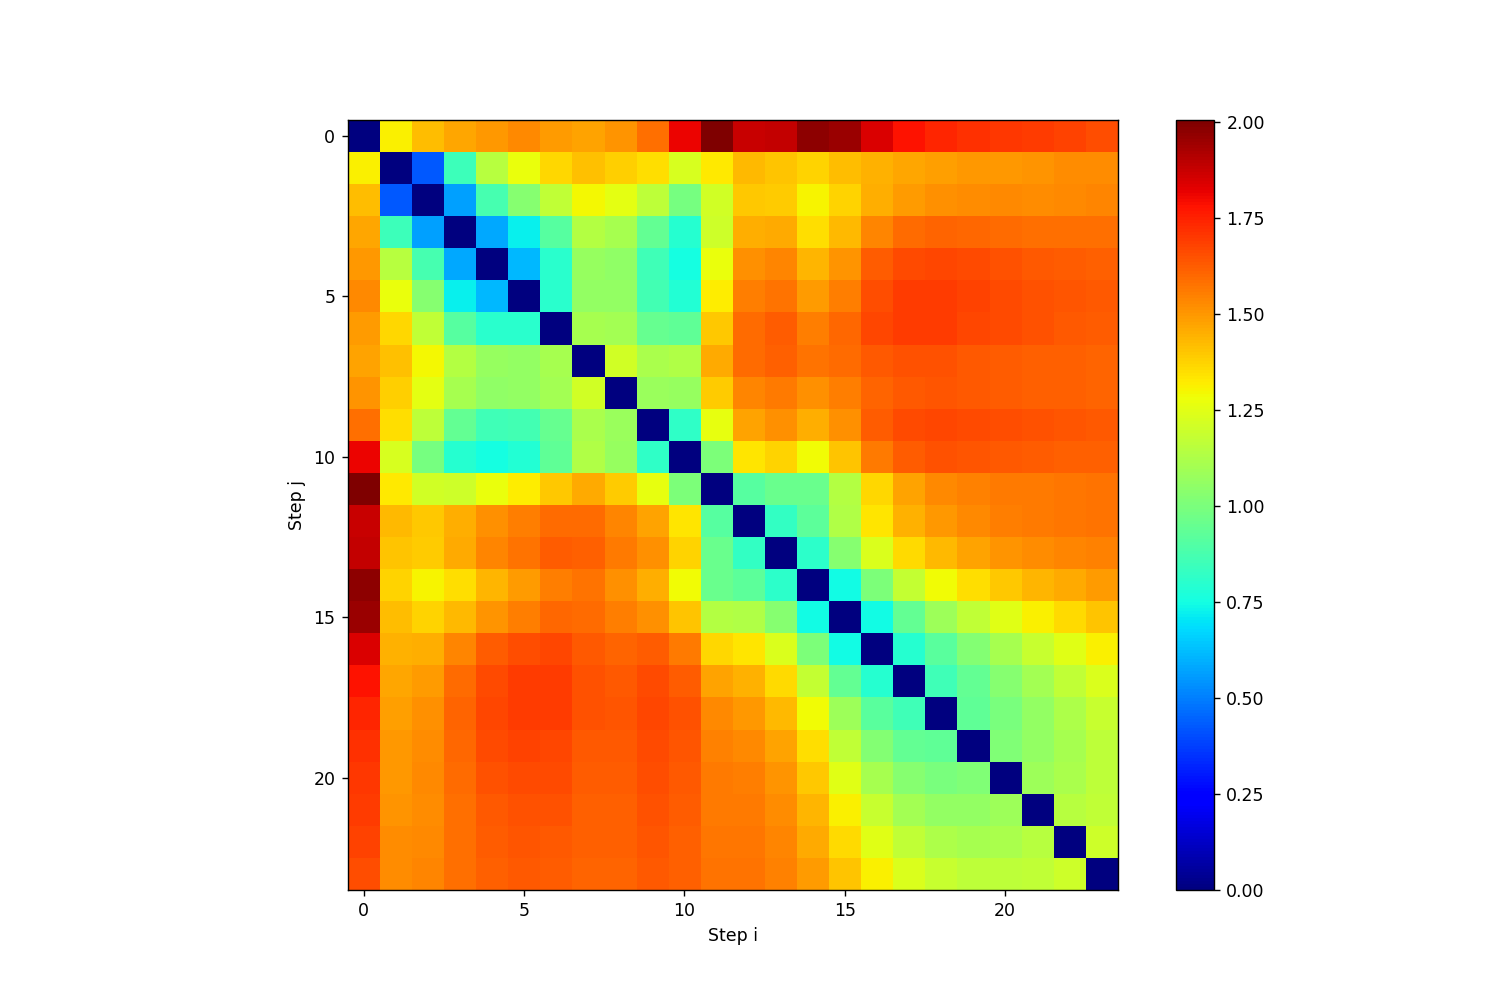

<IPython.core.display.Javascript object>


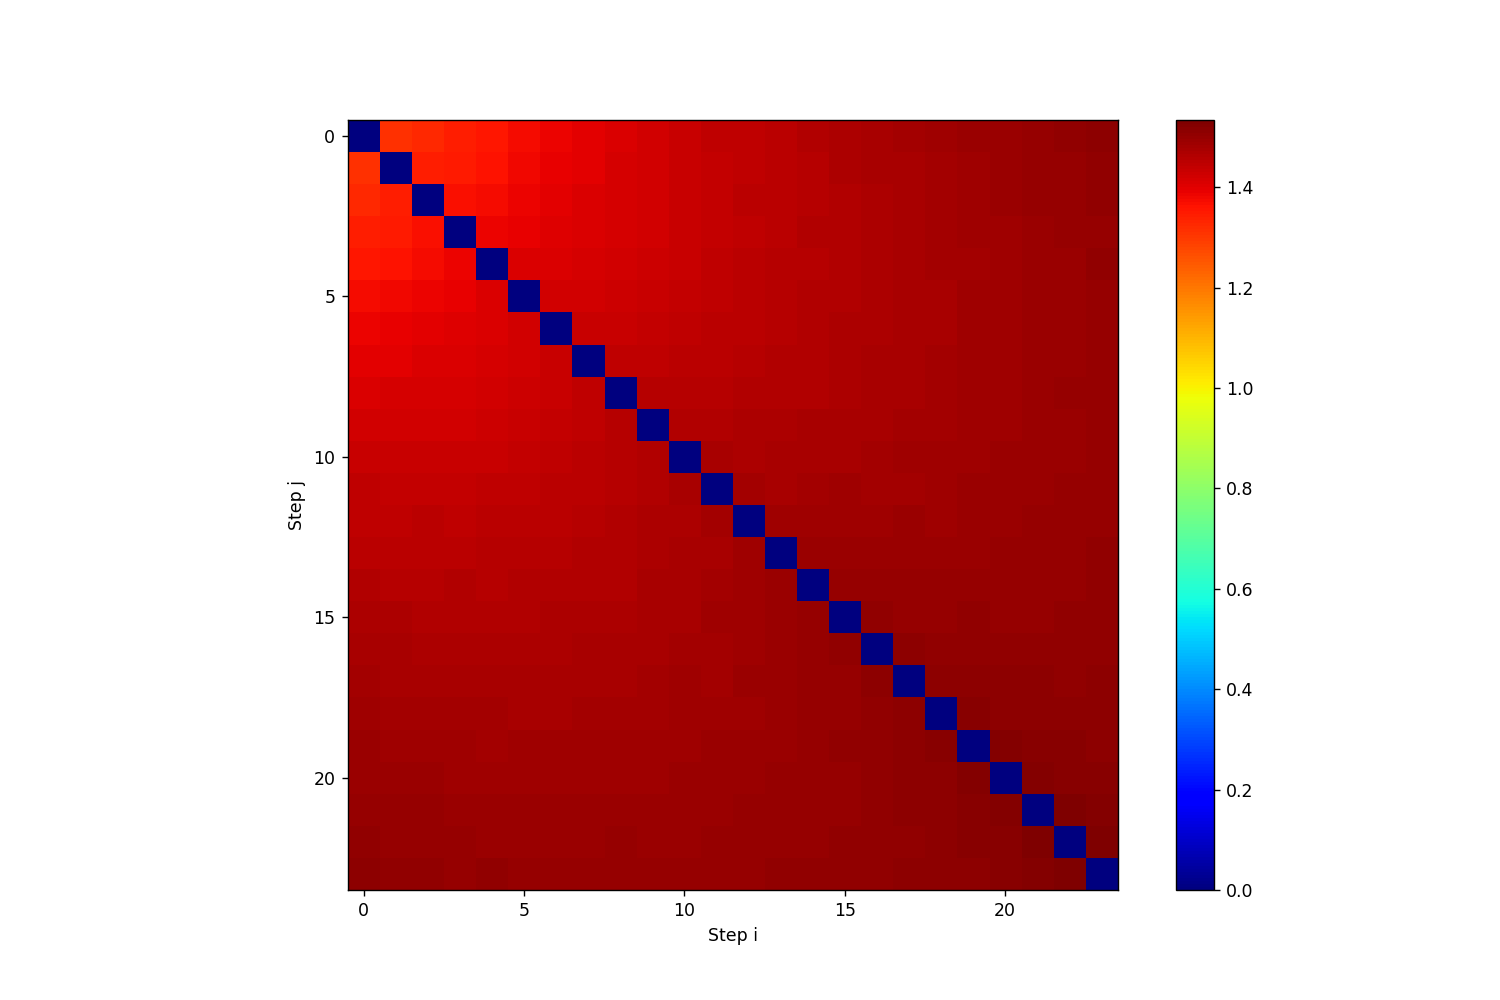

<IPython.core.display.Javascript object>


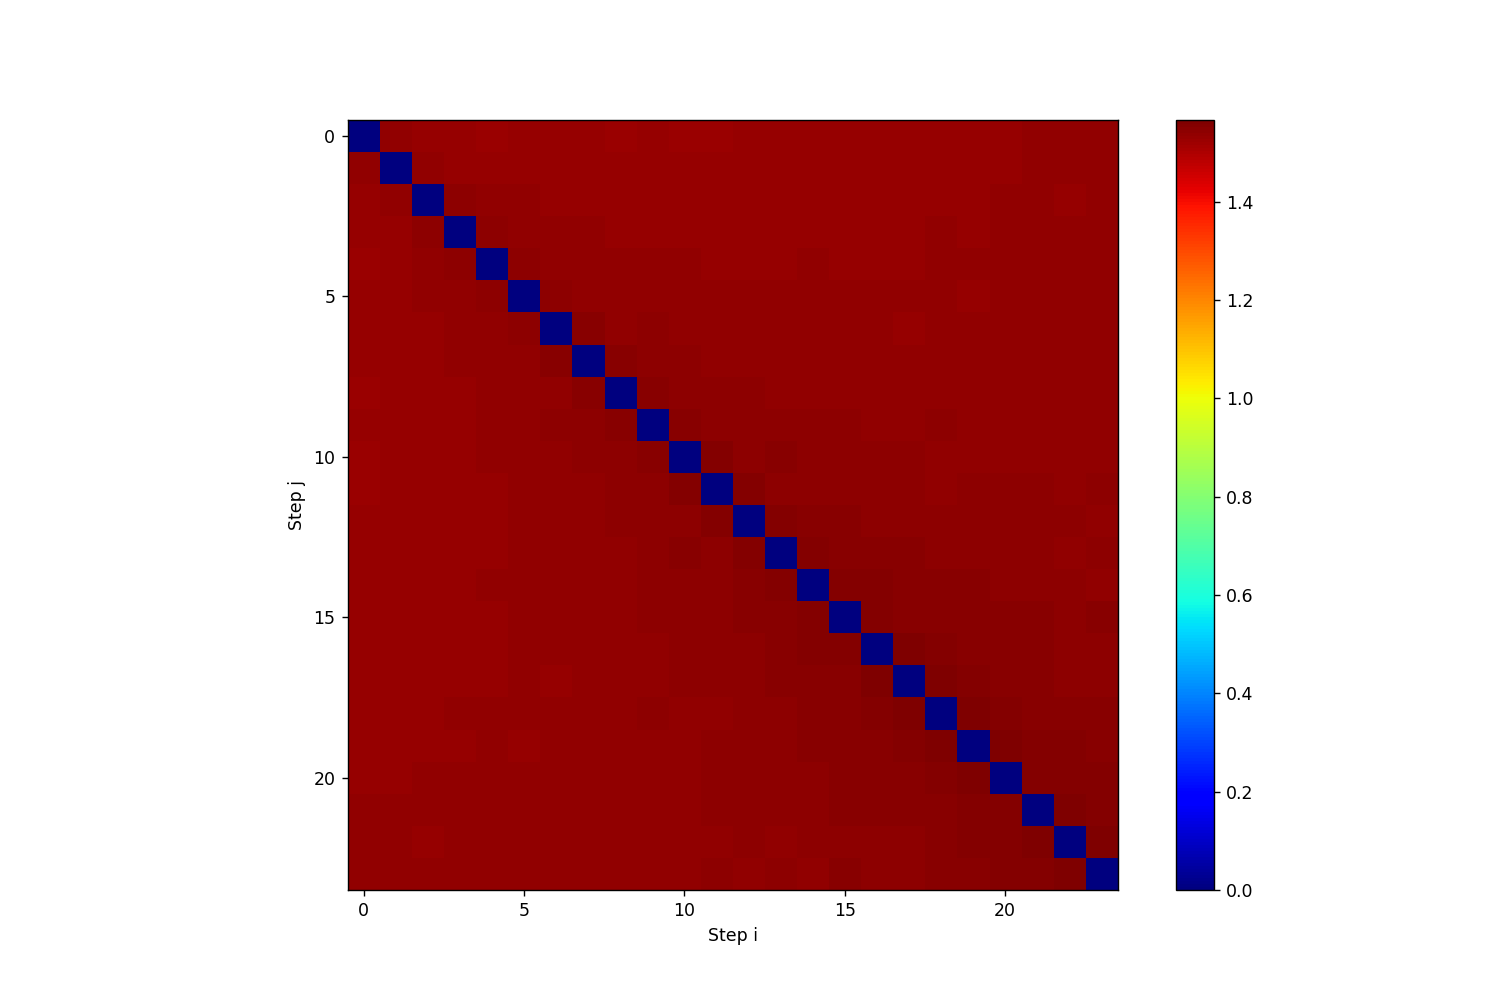

<IPython.core.display.Javascript object>


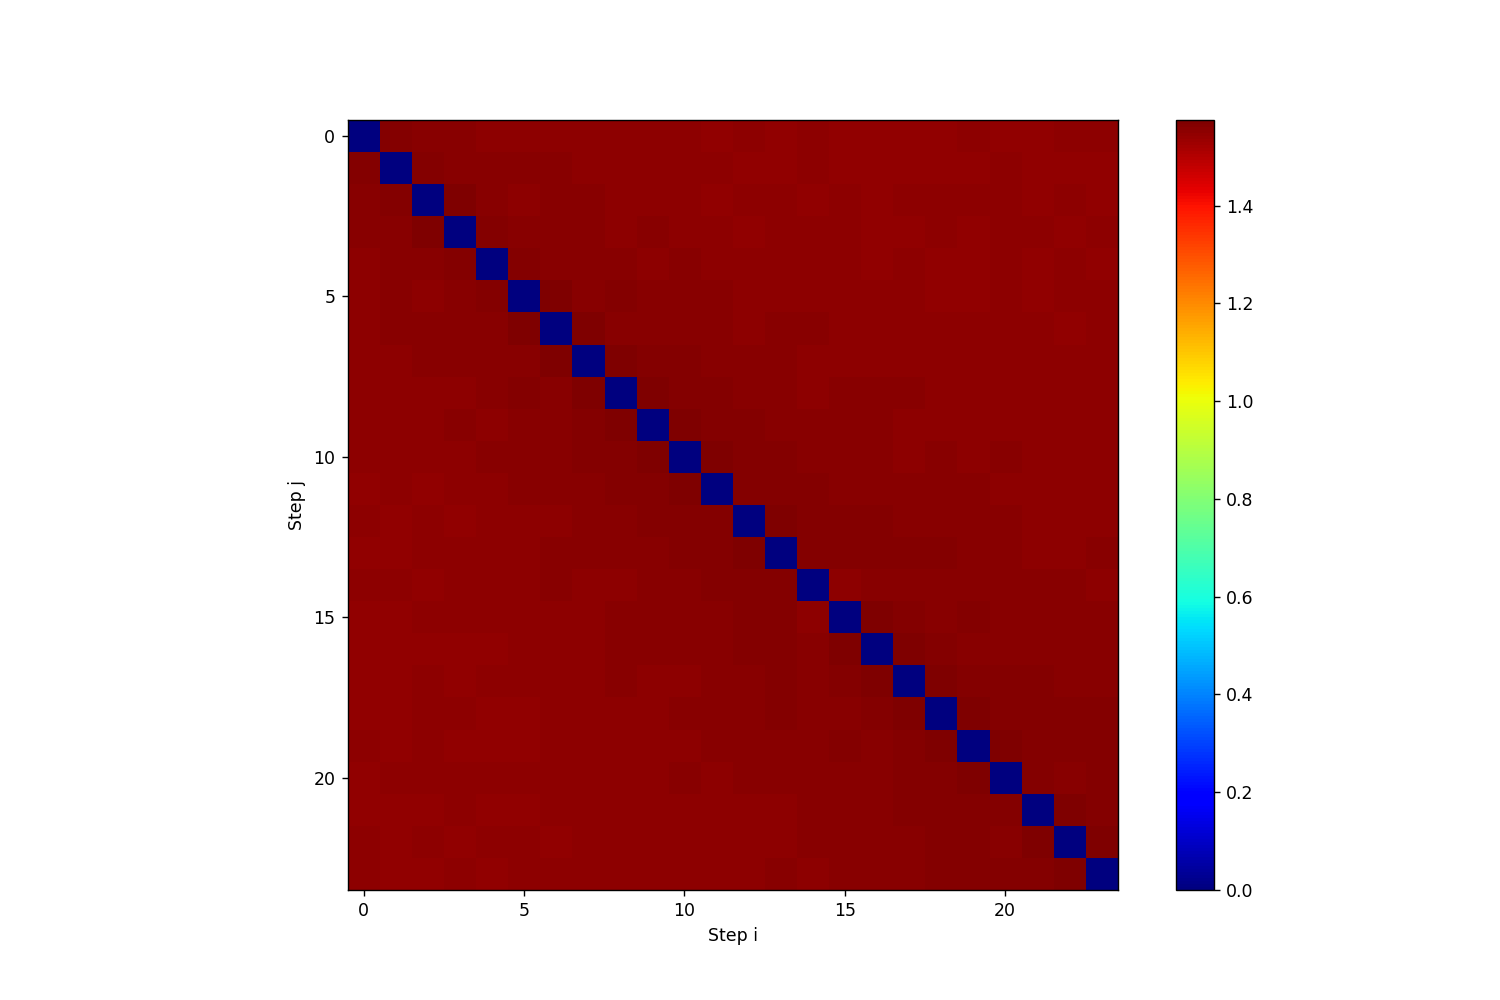

<IPython.core.display.Javascript object>


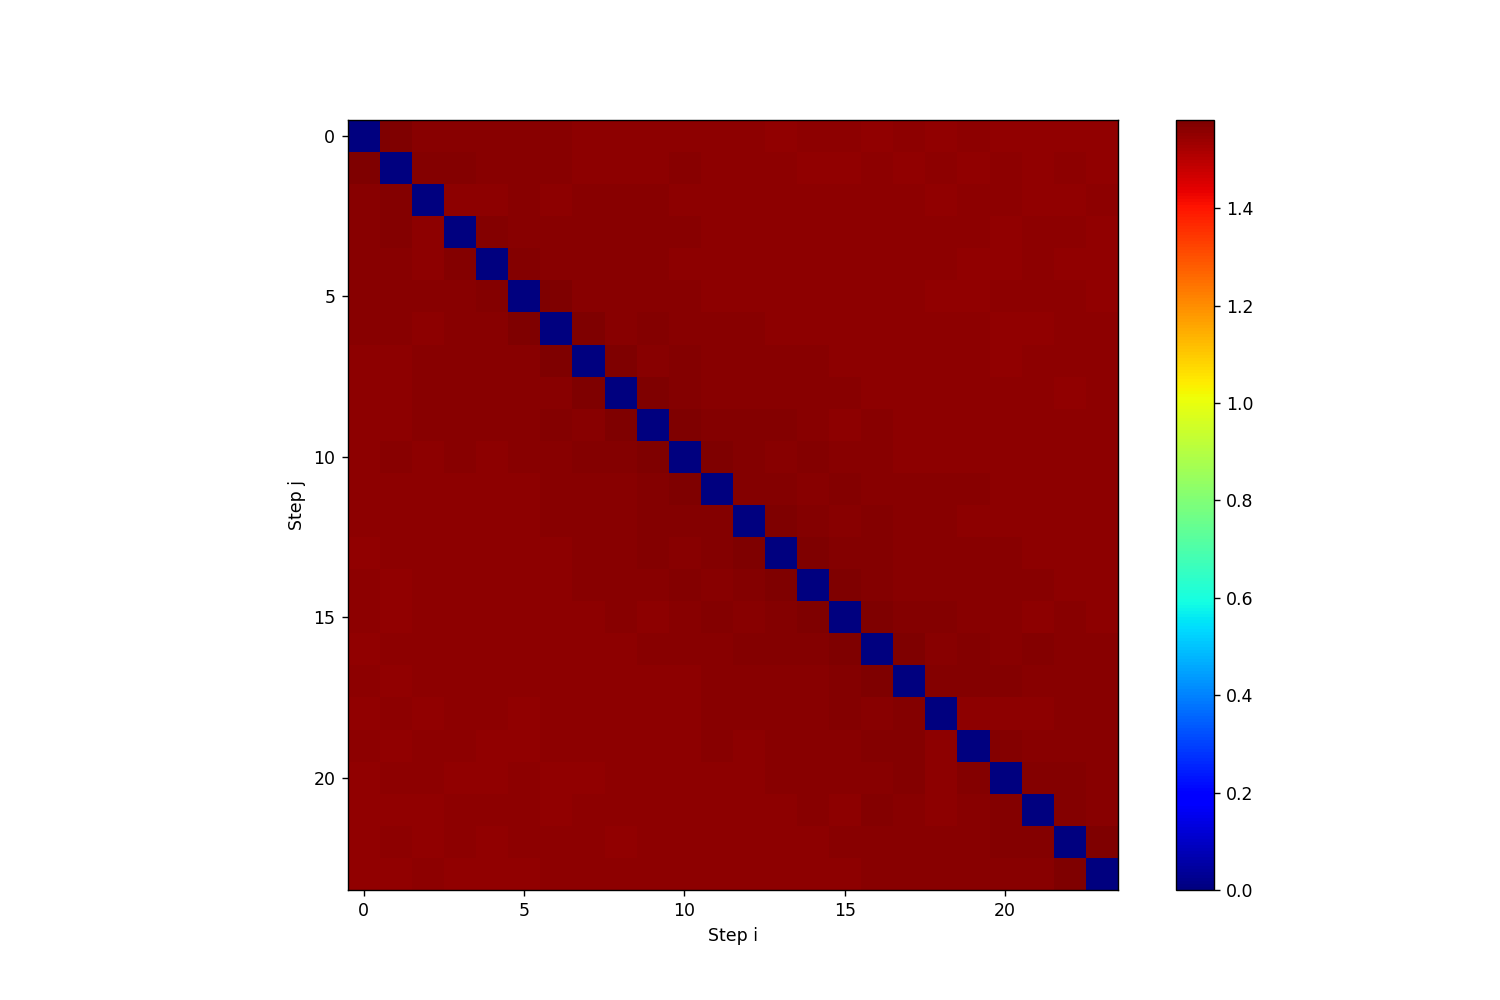

<IPython.core.display.Javascript object>


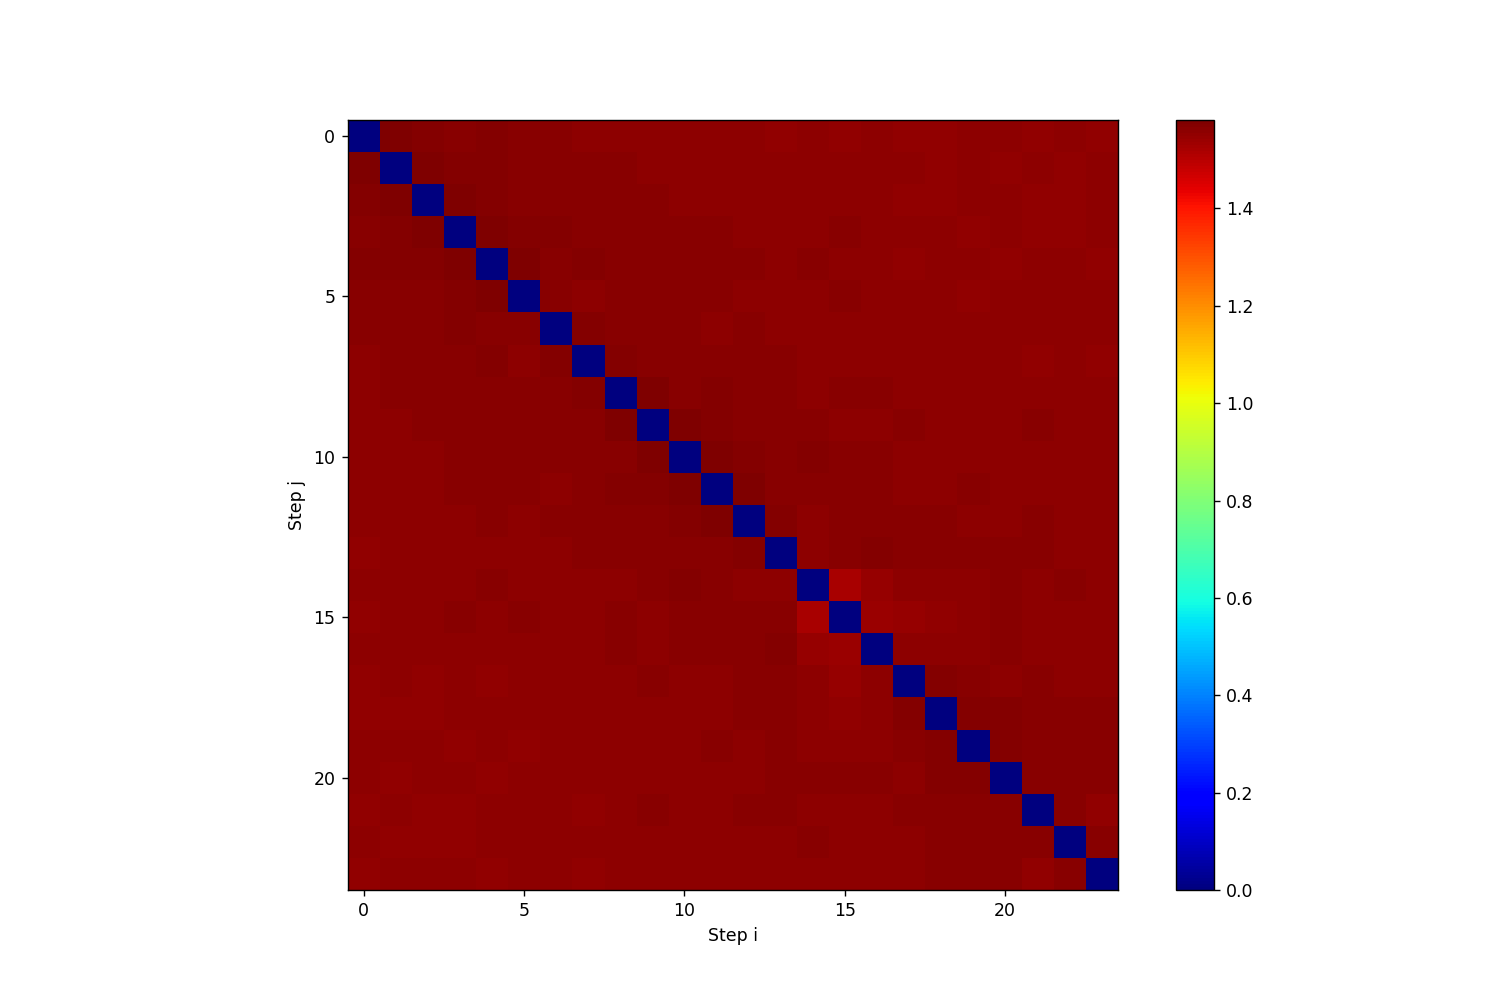

<IPython.core.display.Javascript object>


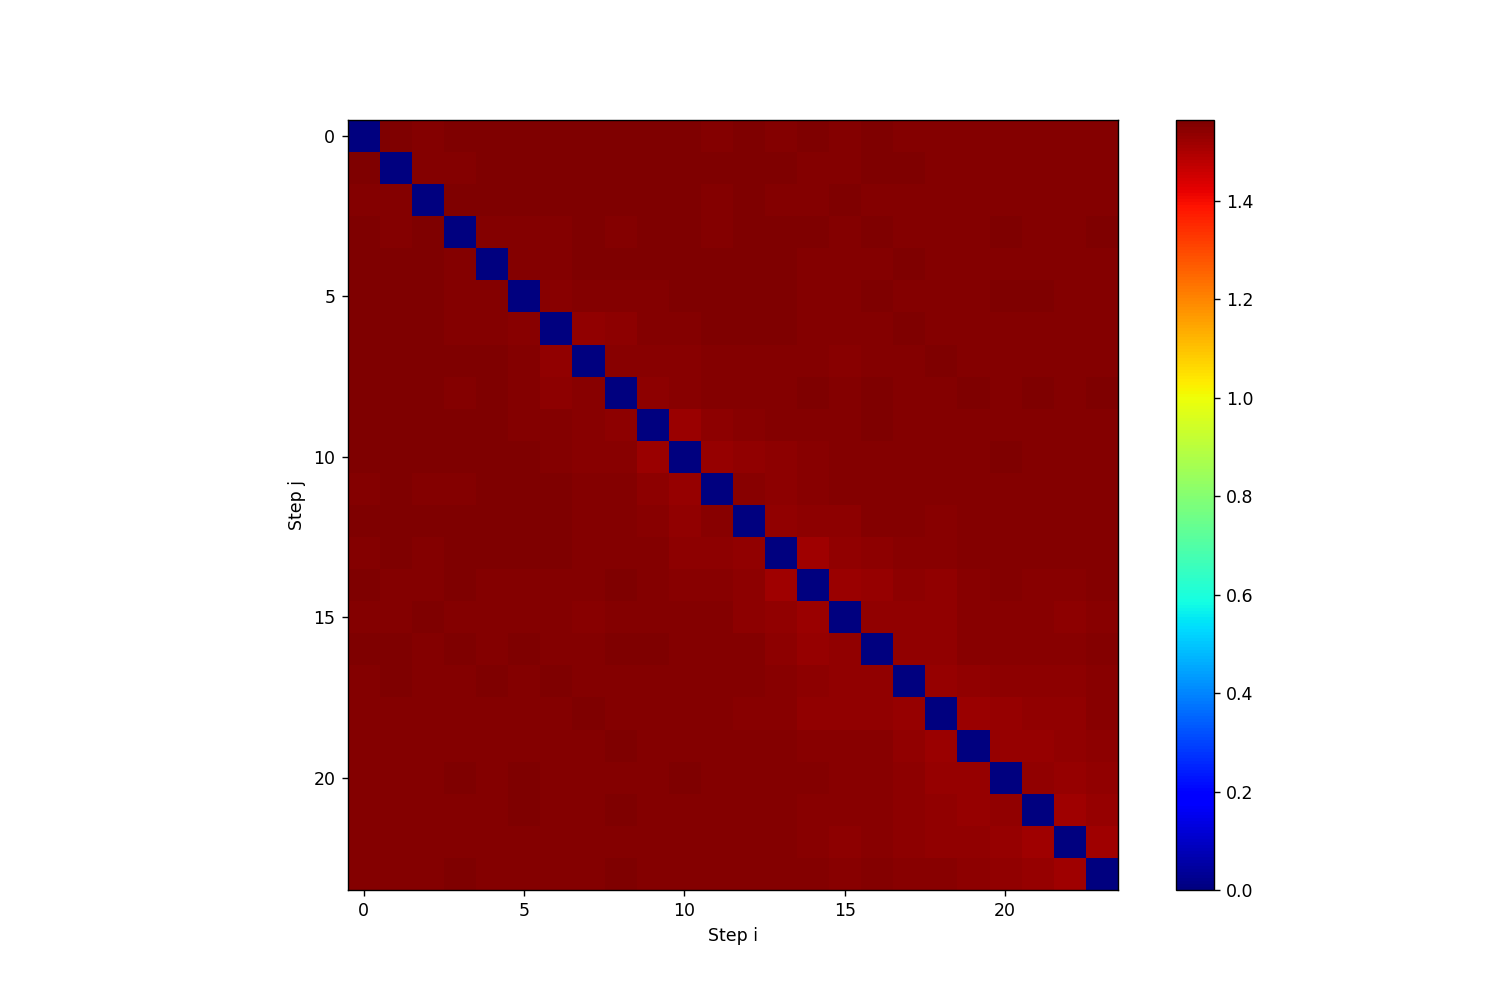

<IPython.core.display.Javascript object>


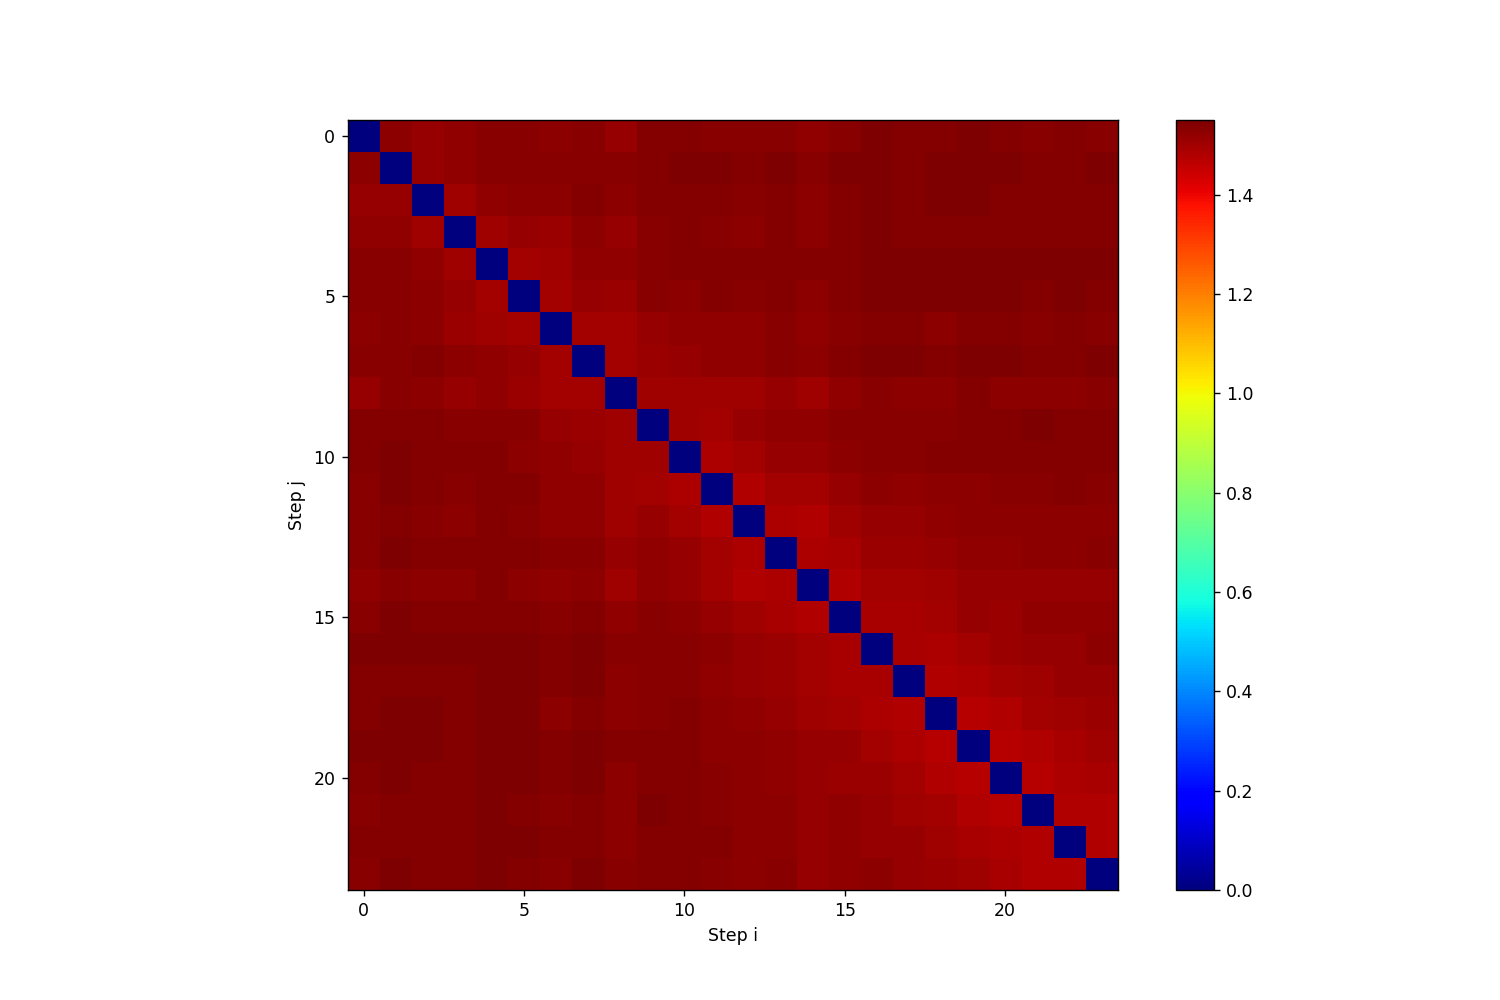

In [23]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [22]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 0.01204 s


OSError: Unable to open file (unable to open file: name = 'dataAA/20K_POCA_kernel_evts_200926.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)